# scverse interoperability

In [1]:
from warnings import filterwarnings

In [2]:
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=FutureWarning)

Please install `squidpy` and its dependencies as well for this tutorial. Refer to its installation guide, should the following not work: `pip install --upgrade squidpy "dask[dataframe]"`

In [3]:
import numpy as np
import pandas as pd
import squidpy as sq
from skimage.transform import downscale_local_mean

import spatiomic as so

## Data loading

In [4]:
image_id = "245 g1"

In [5]:
# read the image and convert the dimension order to XYC/channel-last
img_data = so.data.read().read_tiff(
    f"./data/mouse_cgn/{image_id}.tif",
    input_dimension_order="CYX",
)
img_data = downscale_local_mean(img_data, (4, 4, 1))

# load the clustered image
clustered_img = np.load(f"./data/mouse_cgn/{image_id}-labelled.npy")

# load the channel list
channels = list(pd.read_csv("./data/mouse_cgn/channel_names.csv", header=0).T.to_numpy()[0])

img_data.shape, clustered_img.shape

((438, 438, 35), (438, 438))

## Identify spatial neighbors

In [6]:
neighborhood_offset = so.spatial.neighborhood_offset(
    neighborhood_type="queen",
    order=1,
    exclude_inner_order=0,
)

In [7]:
spatial_weights = so.spatial.spatial_weights(
    data_shape=img_data.shape[:2],
    neighborhood_offset=neighborhood_offset,
)

Creating spatial weights for each offset: 100%|██████████| 8/8 [00:00<00:00, 1409.44it/s]


## Convert to AnnData

In [8]:
adata = so.data.anndata_from_array(
    img_data,
    channel_names=channels,
    clusters=clustered_img,
    spatial_weights=spatial_weights,
)

In [9]:
colormap = so.plot.colormap(
    color_count=np.max(clustered_img) + 1,
    flavor="glasbey",
    color_override={
        1: "#000000",
    },
)
adata.uns["cluster_colors"] = colormap

## Use `AnnData` with `spatiomic`

Many commonly used spatiomic methods also support `AnnData` objects. You can specify where `spatiomic` should look for input data by passing the extra argument `input_attribute`, `input_obs`, `input_obsm`, etc. to the method. Similarly, if you want to decide where the output should be stored, you can use keyword arguments like `output_attribute`, `output_obs`, `output_uns`, etc. Note that the `AnnData` object is modified in place and the standard `spatiomic` output is returned.

In [10]:
zscorer = so.process.zscore()

# This will return the standard ND-array but also update the `adata` object in place and add the X_zscored layer
zscored_values = zscorer.fit_transform(adata)
type(zscored_values), adata

(numpy.ndarray,
 AnnData object with n_obs × n_vars = 191844 × 35
     obs: 'clusters'
     uns: 'cluster_colors'
     obsm: 'spatial'
     layers: 'X_zscored'
     obsp: 'spatial_connectivities')

Methods that currently support `AnnData` objects include:
- `spatiomic.cluster.agglomerative`
- `spatiomic.cluster.kmeans`
- `spatiomic.cluster.leiden`
- `spatiomic.data.subsample`
- `spatiomic.dimension.pca`
- `spatiomic.dimension.som`
- `spatiomic.dimension.tsne`
- `spatiomic.dimension.umap`
- `spatiomic.process.clip`
- `spatiomic.process.log1p`
- `spatiomic.process.normalize`
- `spatiomic.process.zscore`

## Use with `scverse` tools

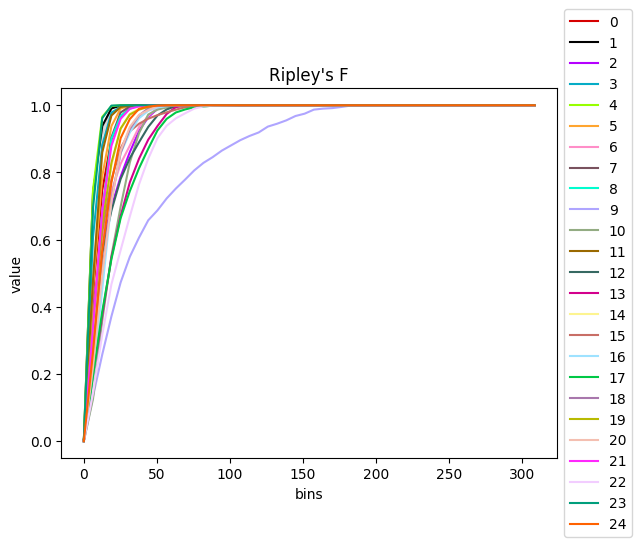

In [11]:
sq.gr.ripley(adata, cluster_key="clusters")
sq.pl.ripley(
    adata,
    cluster_key="clusters",
    palette=adata.uns["cluster_colors"],
)

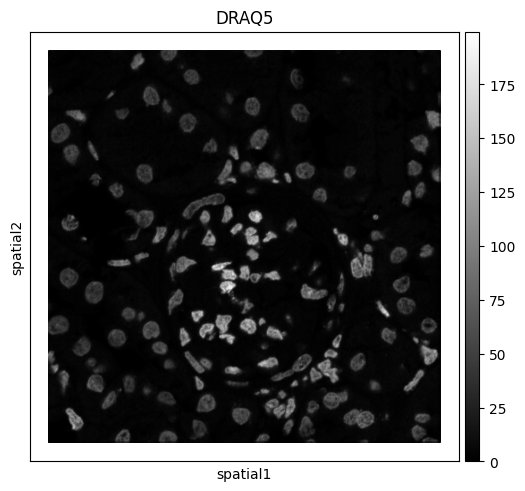

In [12]:
sq.pl.spatial_scatter(adata, color="DRAQ5", size=1, shape=None, cmap="gray")

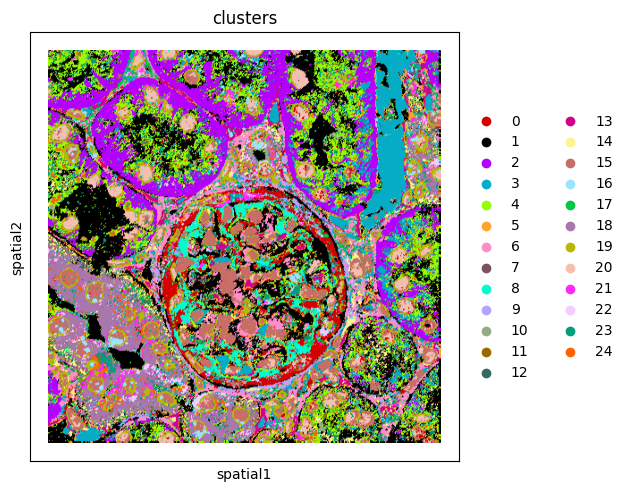

In [13]:
sq.pl.spatial_scatter(adata, color="clusters", size=1, shape=None, palette=adata.uns["cluster_colors"])